# Learning and causality

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

## Model

Let's assume a process $X_1\rightarrow Y_1$ with a control on $X_1$ by $C_a$ and a parameter $P_b$ on $Y_1$.

In [2]:
bn=gum.fastBN("Ca->X1->Y1<-Pb")
bn.cpt("Ca").fillWith([0.8,0.2])
bn.cpt("Pb").fillWith([0.3,0.7])

bn.cpt("X1")[:]=[[0.9,0.1],[0.1,0.9]]

bn.cpt("Y1")[{"X1":0,"Pb":0}]=[0.8,0.2]
bn.cpt("Y1")[{"X1":1,"Pb":0}]=[0.2,0.8]
bn.cpt("Y1")[{"X1":0,"Pb":1}]=[0.6,0.4]
bn.cpt("Y1")[{"X1":1,"Pb":1}]=[0.4,0.6]

gnb.flow.row(bn,*[bn.cpt(x) for x in bn.nodes()])

Actually the process is duplicated in the system but the control $C_a$ and the parameter $P_b$ are shared.

In [3]:
bn.add("X2",2)
bn.add("Y2",2)
bn.addArc("X2","Y2")
bn.addArc("Ca","X2")
bn.addArc("Pb","Y2")

bn.cpt("X2").fillWith(bn.cpt("X1"),["X1","Ca"]) # copy cpt(X1) with the translation X2<-X1,Ca<-Ca
bn.cpt("Y2").fillWith(bn.cpt("Y1"),["Y1","X1","Pb"]) # copy cpt(Y1) with translation Y2<-Y1,X2<-X1,Pb<-Pb

gnb.flow.row(bn,bn.cpt("X2"),bn.cpt("Y2"))

## Simulation of the data

The process is partially observed : the control has been taken into account. However the parameter has not been identified and therefore is not collected.

In [4]:
#the base will be saved in completeData="out/complete_data.csv", observedData="out/observed_data.csv"
import os
completeData="out/complete_data.csv"
observedData="out/observed_data.csv"
fixedObsData="res/fixed_observed_data.csv"

# generating complete date with pyAgrum
size=35000
#gum.generateSample(bn,5000,"data.csv",random_order=True)
generator=gum.BNDatabaseGenerator(bn)
generator.setRandomVarOrder()
generator.drawSamples(size)
generator.toCSV(completeData)

In [5]:
# selecting some variables using pandas
import pandas as pd
f=pd.read_csv(completeData)
keep_col = ["X1","Y1","X2","Y2","Ca"] # Pb is removed
new_f = f[keep_col]
new_f.to_csv(observedData, index=False)

In order to have fixed results, we will use now a database <tt>fixed_observed_data.csv</tt> generated with the process above.

## statistical learning

Using a classical statistical learning method, one can approximate a model from the observed data.

In [6]:
learner=gum.BNLearner(fixedObsData)
learner.useGreedyHillClimbing()
bn2=learner.learnBN()

## Evaluating the impact of $X2$ on $Y1$

Using the database, a question for the user is to evaluate the impact of the value of $X2$ on $Y1$.

In [7]:
target="Y1"
evs="X2"
ie=gum.LazyPropagation(bn)
ie2=gum.LazyPropagation(bn2)
p1=ie.evidenceImpact(target,[evs])
p2=gum.Potential(p1).fillWith(ie2.evidenceImpact(target,[evs]),[target,evs])
errs=((p1-p2)/p1).scale(100)
quaderr=(errs*errs).sum()
gnb.flow.row(p1,p2,errs,f"$${quaderr:3.5f}$$",
              captions=['in original model','in learned model','relative errors','quadratic error'])


## Evaluating the causal impact of $X2$ on $Y1$ with the learned model

The statistician notes that the change wanted by the user to apply on $X_2$ is not an observation but rather an intervention.

In [8]:
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

model=csl.CausalModel(bn)
model2=csl.CausalModel(bn2)

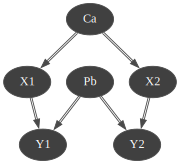

In [9]:
cslnb.showCausalModel(model)

In [10]:
gum.config['notebook','graph_format']='svg'
cslnb.showCausalImpact(model,on=target, doing={evs})
cslnb.showCausalImpact(model2,on=target, doing={evs})

Unfortunately, due to the fact that $P_a$ is not learned, the computation of the causal impact still is imprecise.

In [11]:
_, impact1, _ = csl.causalImpact(model, on=target, doing={evs})
_, impact2orig, _ = csl.causalImpact(model2, on=target, doing={evs})

impact2=gum.Potential(p2).fillWith(impact2orig,['Y1','X2'])
errs=((impact1-impact2)/impact1).scale(100)
quaderr=(errs*errs).sum()
gnb.flow.row(impact1,impact2,errs,f"$${quaderr:3.5f}$$",
              captions=['$P( Y_1 \mid \hookrightarrow X_2)$ <br/>in original model',
                        '$P( Y_1 \mid \hookrightarrow X_2)$  <br/>in learned model',' <br/>relative errors',' <br/>quadratic error'])

Just to be certain, we can verify that in the original model, $P( Y_1 \mid \hookrightarrow X_2)=P(Y_1)$

In [12]:
gnb.flow.row(impact1,ie.evidenceImpact(target,[]),
               captions=["$P( Y_1 \mid \hookrightarrow X_2)$ <br/>in the original model","$P(Y_1)$ <br/>in the original model"])

## Causal learning and causal impact

Some learning algorthims such as MIIC (Verny et al., 2017) aim to find the trace of latent variables in the data

In [13]:
learner=gum.BNLearner(fixedObsData)
learner.useMIIC()
bn3=learner.learnBN()

In [14]:
gnb.flow.row(bn,bn3,f"$${[(bn3.variable(i).name(),bn3.variable(j).name()) for (i,j) in learner.latentVariables()]}$$",
              captions=['original model','learned model','Latent variables found'])

Then we can build a causal model taking into account this latent variable found by MIIC.

In [15]:
model3=csl.CausalModel(bn2,[("L1",("Y1","Y2"))])
cslnb.showCausalImpact(model3,target, {evs})

Then at least, the statistician can say that $X_2$ has no impact on $Y_1$ from the data. The error is just due to the approximation of the parameters in the database.

In [16]:
_, impact1, _ = csl.causalImpact(model, on=target, doing={evs})
_, impact3orig, _ = csl.causalImpact(model3, on=target, doing={evs})

impact3=gum.Potential(impact1).fillWith(impact3orig,['Y1'])
errs=((impact1-impact3)/impact1).scale(100)
quaderr=(errs*errs).sum()
gnb.flow.row(impact1,impact3,errs,f"$${quaderr:3.5f}$$",
              captions=['in original model','in learned model','relative errors','quadratic error'])